This is the sequel of tutorial_training_dnn.ipynb.

Here, we will discuss about loading a trained network, forwarding data to it and how to extract features maps.

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
from matplotlib import pyplot as plt
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

First, you can load a model using load_model from Keras to load an hdf5 file containing a network (saved using save_model or a ModelCheckpoint also defined in Keras).

Otherwise, using the DeepNet class, you can call the constructor with the file.

In [2]:
# Input the hdf5 file, here we load a network trained on Tikhonov
net_file = 'Deconv_net_tuto_copy.hdf5'
### Method 1
#from keras.models import load_model
#dnn = load_model(net_file) #dnn is instance of the model class

### Method 2
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
dnn = DeepNet(model_file=net_file) #dnn is instance of DeepNet class

Using TensorFlow backend.


Loading model in DeepNet...
Deconv_net_tuto_copy.hdf5


In [3]:
dnn_alexis=DeepNet(model_file="../nets/DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5")

Loading model in DeepNet...
../nets/DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5


In [4]:
dnn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 96, 96, 32)   288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 96, 96, 32)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 96, 96, 32)   0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
separable_

We also load a traditionnal CNN network

In [4]:
from keras.models import load_model
kk=load_model('/data/DeepDeconv/model/archive/unet_vs_cnn/cnn.hdf5')

We then print the structure of the network:

In [6]:
kk.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 48)   480         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 48)   192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 48)   20784       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

And display the structure of the network:

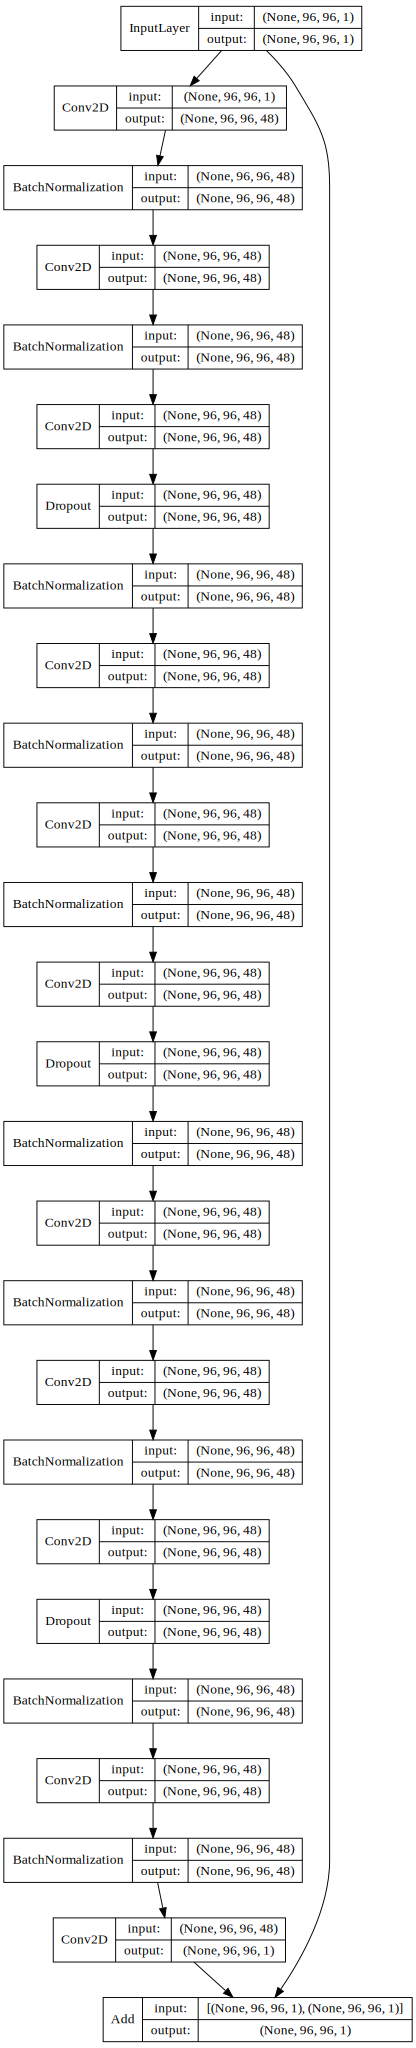

In [7]:
from keras.utils import plot_model
plot_model(kk, to_file='{0}.png'.format("CNN_10_layers"),show_shapes=True)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

pydot_obj=model_to_dot(kk,show_shapes=True,show_layer_names=False)
SVG(pydot_obj.create(prog='dot', format='svg'))

To forward data through the network use the predict method available for both classes. For the method 2:

In [5]:
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np

# Input the file containing the galaxies and psfs for testing
testset_file = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits'
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

# Create the set of test with 10 observations at SNR 50
test_data, target_data = get_batch_from_fits(testset_file, idx_list=np.arange(10), SNR=50,
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                        image_dim=96, image_per_row=100,
                        deconv_mode='TIKHONOV')
noisy_data, target_data = get_batch_from_fits(testset_file, idx_list=np.arange(10), SNR=50,
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                        image_dim=96, image_per_row=100,
                        deconv_mode=None)

dnn_reconstruction = dnn.predict(test_data, verbose=1)
print(dnn_reconstruction.shape)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@batch_normalization_1/cond/FusedBatchNorm/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
	 [[{{node conv2d_4/BiasAdd/_3673}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_382_conv2d_4/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Using DNN from Alexis:

In [8]:
dnn_reconstruction_alexis = dnn_alexis.predict(test_data, verbose=1)
print(dnn_reconstruction.shape)

10/10 [==============================] - 2s 235ms/step
(10, 96, 96, 1)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0627c0f828>,
 <matplotlib.image.AxesImage at 0x7f0627bfddd8>)

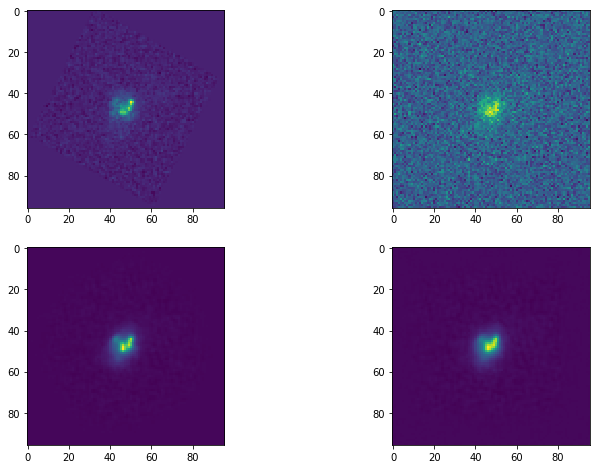

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(221),plt.imshow(target_data[0,:,:,0])
plt.subplot(222),plt.imshow(noisy_data[0,:,:,0])
plt.subplot(223),plt.imshow(dnn_reconstruction_alexis[0,:,:,0])
plt.subplot(224),plt.imshow(dnn_reconstruction[0,:,:,0])

The DeepNet class also provides a method to extract intermediate features maps:

    get_layer_output(test_data, layer_idx)
    
layer_idx (int): idx of the layer whose features maps will be extracted.

Use dnn.model.summary() to retrieve the layers list.

In [18]:
dnn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
separable_

In [10]:
# Suppose we want the last concatenation layer
idx = -4

# We print the name to check if you have the correct layer
print(dnn.model.layers[idx].name)

# We extract the features maps for the same data set as above.
# The layer has 48 neurons so we get an output of shape (10,96,96,48)
feat_maps = dnn.get_layer_output(test_data, layer_idx=idx)
print(feat_maps.shape)

concatenate_55
(10, 96, 96, 40)


<Figure size 1152x1152 with 0 Axes>

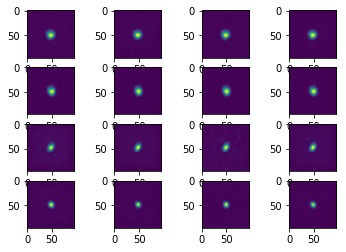

In [11]:
plt.figure(figsize=(16,16))
fig,axes=plt.subplots(4,4)
for kx in range(4):
    for ky in range(4):
        axes[kx, ky].imshow(feat_maps[kx,:,:,ky])

